In [ ]:
# Import necessary libraries for data processing, hashing, and similarity calculation

import pandas as pd
import numpy as np
import json
import nltk
import string
import requests
import copy
import random
import nltk

from scipy.sparse import lil_matrix
from nltk import ngrams
from collections import Counter
from scipy.sparse import csr_matrix
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from itertools import combinations


In [ ]:
# Fetch article dataset from the provided URL

url = 'https://www.ux.uis.no/~vsetty/data/assignment2_aricles.json'
response = requests.get(url)
articles = response.json()

In [ ]:
#Convert text to lowercase, remove punctuation, and normalize spaces

def preprocess_text(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

In [ ]:
## Take sample from content of articles


print("First article content:", articles[0].get('content', ''))
print("First article title:", articles[0].get('title', ''))

First article content: 
First article title: 


In [ ]:
"""
    Extract and return the most frequent n-grams from articles.
    - Uses word-level bigrams (n=2) as default.
    - Processes both content and title of each article.
    - Returns a dictionary mapping each n-gram to an index.
    """

def getFrequentNgrams(articles, n=2, top_k=10000):
    all_ngrams = []

    for article in articles:
        text = preprocess_text(article.get("Content", "") + " " + article.get("Title", ""))
        doc_ngrams = ['_'.join(gram) for gram in ngrams(text.split(), n)]
        all_ngrams.extend(doc_ngrams)

    # Count occurrences and select top-k most frequent n-grams
    ngram_counts = Counter(all_ngrams).most_common(top_k)
    unique_ngrams = [ngram for ngram, _ in ngram_counts]
    
    return unique_ngrams, {ngram: i for i, ngram in enumerate(unique_ngrams)}


In [ ]:
# Extravt n-grams from the first 100 articles

ngrams_sample, ngram_to_index = getFrequentNgrams(articles[:100])

print(f"Extracted {len(ngrams_sample)} unique n-grams")
print("First 5 n-grams:", ngrams_sample[:5])  # Display first few n-grams


Extracted 10000 unique n-grams
First 5 n-grams: ['of_the', 'in_the', 'to_the', 'for_the', 'on_the']


In [ ]:
# Convert articles to a sparse binary matrix indicating presence of n-grams

def getBinaryMatrix(articles, ngram_to_index, n=2):
    num_docs = len(articles)
    num_features = len(ngram_to_index)
    
    # Use a sparse matrix to save memory
    binary_matrix = lil_matrix((num_docs, num_features), dtype=np.int8)
    
    for doc_id, article in enumerate(articles):
        text = preprocess_text(article.get("Content", "") + " " + article.get("Title", ""))
        doc_ngrams = ['_'.join(gram) for gram in ngrams(text.split(), n)]
        
        for ngram in doc_ngrams:
            if ngram in ngram_to_index:
                binary_matrix[doc_id, ngram_to_index[ngram]] = 1  # Mark presence

    return binary_matrix.tocsr()  # Convert to CSR format for efficiency


In [ ]:

binary_matrix = getBinaryMatrix(articles[:100], ngram_to_index)

print("Binary Matrix Shape:", binary_matrix.shape)
print("Total nonzero values:", binary_matrix.nnz)
print("Density of Binary Matrix:", binary_matrix.nnz / binary_matrix.size)


Binary Matrix Shape: (100, 10000)
Total nonzero values: 16046
Density of Binary Matrix: 1.0


In [ ]:
# Generate a list of hash function values for MinHashing

def getHashFunctionValues(numrows, numhashfunctions):
    random.seed(42)  # Ensure reproducibility
    return [[random.randint(0, numrows - 1) for _ in range(numhashfunctions)] for _ in range(numrows)]

In [9]:
num_hashes = 100  # Number of hash functions
hash_val_matrix = getHashFunctionValues(binary_matrix.shape[1], num_hashes)

print(f"Generated hash function matrix of shape: ({len(hash_val_matrix)}, {len(hash_val_matrix[0])})")

Generated hash function matrix of shape: (10000, 100)


In [ ]:
def getMinHashSignatureMatrix(binary_matrix, hash_val_matrix):
    """Compute the MinHash signature matrix."""
    num_docs, num_features = binary_matrix.shape
    num_hashes = len(hash_val_matrix[0])

    # Initialize the signature matrix with large integer values
    signature_matrix = np.full((num_docs, num_hashes), np.iinfo(np.int32).max, dtype=np.int32)

    # Compute MinHash signatures
    for doc_id in range(num_docs):
        for ngram_idx in binary_matrix[doc_id].nonzero()[1]:
            for hash_idx, hash_val in enumerate(hash_val_matrix[ngram_idx]):
                signature_matrix[doc_id, hash_idx] = min(signature_matrix[doc_id, hash_idx], hash_val)

    return signature_matrix

In [ ]:
signature_matrix = getMinHashSignatureMatrix(binary_matrix, hash_val_matrix)

print("Signature Matrix Shape:", signature_matrix.shape)
print("First 5 rows of Signature Matrix:")
print(signature_matrix[:5, :5])

Signature Matrix Shape: (100, 100)
First 5 rows of Signature Matrix:
[[ 29  27   1 245  10]
 [ 21  11  10  46   3]
 [ 66  16 111  75 276]
 [ 62  10  17  39 159]
 [ 20  22  43  28  45]]


In [ ]:
from collections import defaultdict

def getLSH(signature_matrix, num_bands, num_buckets):
    """Hash signature matrix into LSH buckets using multiple bands."""
    num_docs, num_hashes = signature_matrix.shape

    # Ensure number of hashes is divisible by num_bands
    if num_hashes % num_bands != 0:
        raise ValueError("Number of hashes must be divisible by number of bands")

    rows_per_band = num_hashes // num_bands
    lsh_buckets = defaultdict(set)

    for band in range(num_bands):
        for doc_id in range(num_docs):
            band_signature = tuple(signature_matrix[doc_id, band * rows_per_band:(band + 1) * rows_per_band])
            bucket = hash(band_signature) % num_buckets
            lsh_buckets[bucket].add(doc_id)

    return lsh_buckets


In [12]:
num_bands = 10
num_buckets = 10000  # Increase buckets to avoid too many collisions
signature_matrix = getMinHashSignatureMatrix(binary_matrix, hash_val_matrix)

lsh_buckets = getLSH(signature_matrix, num_bands, num_buckets)
print(f"Total LSH Buckets: {len(lsh_buckets)}")

Total LSH Buckets: 953


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plotProbability(s, b, r):
    """Plot the probability of two similar items falling in the same bucket."""
    threshold_values = np.linspace(0.01, 1, 100)
    probabilities = [1 - (1 - (threshold**r))**b for threshold in threshold_values]

    plt.plot(threshold_values, probabilities)
    plt.xlabel("Jaccard Similarity Threshold (s)")
    plt.ylabel("Probability of Bucketing")
    plt.title(f"LSH Probability (b={b}, r={r})")
    plt.grid(True)
    plt.show()

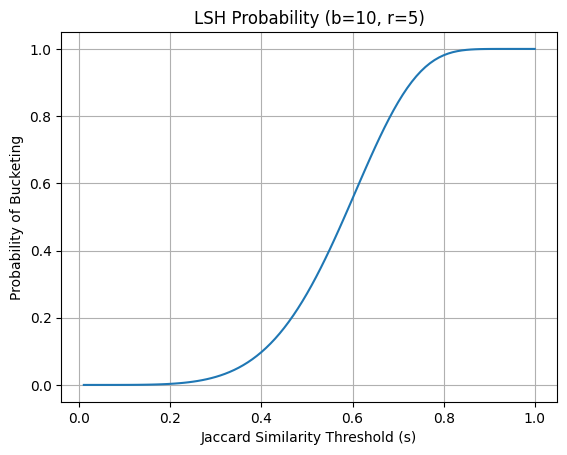

In [ ]:
plotProbability(s=0.5, b=10, r=5)

In [ ]:
# Compute Jaccard similarity score between two sets

def getJaccardSimilarityScore(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

In [16]:
set_a = {1, 2, 3, 4}
set_b = {3, 4, 5, 6}

print(f"Jaccard Similarity: {getJaccardSimilarityScore(set_a, set_b)}")

Jaccard Similarity: 0.3333333333333333


In [ ]:
nearest_neighbors = defaultdict(set)

for bucket in lsh_buckets.values():
    docs = list(bucket)
    if len(docs) > 1:
        for doc1, doc2 in combinations(docs, 2):
            nearest_neighbors[doc1].add(doc2)
            nearest_neighbors[doc2].add(doc1)

print(f"Total nearest neighbors: {len(nearest_neighbors)}")

Total nearest neighbors: 59


In [ ]:
threshold_s = 0.2
n_copy = copy.deepcopy(nearest_neighbors)
submission_id = []
submission_nid = []

for article_id, neighbor_ids in n_copy.items():
    for nid in neighbor_ids:
        score = getJaccardSimilarityScore(set(articles[article_id]["Content"].split()), 
                                          set(articles[nid]["Content"].split()))
        if score >= threshold_s:
            submission_id.append(article_id)
            submission_nid.append(nid)

print(f"Filtered neighbors based on Jaccard Similarity (s={threshold_s})")

Filtered neighbors based on Jaccard Similarity (s=0.2)


In [ ]:
n_copy = copy.deepcopy(nearest_neighbors)  # Ensure no modification in original data
submission_id = []
submission_nid = []

for article_id, neighbor_ids in n_copy.items():
    for nid in neighbor_ids:
        submission_id.append(article_id)
        submission_nid.append(nid)

print(f"Collected {len(submission_id)} pairs for submission")

Collected 98 pairs for submission


In [ ]:
data = pd.DataFrame()
data["article_id"] = submission_id
data["neighbor_id"] = submission_nid
data.sort_values(by=["article_id", "neighbor_id"], inplace=True)

data.to_csv("submissions.csv", index=False)

print("Submission file created: submissions.csv")

Submission file created: submissions.csv


In [22]:
data.head(100)

,article_id,neighbor_id
82,0,99
83,3,15
3,5,99
16,7,42
15,7,48
...,...,...
92,96,13
93,96,79
0,99,0
1,99,5
